In [2]:
from experiments.run_experiments import *
from utilities.model_matching_computation import *


For [nawba]: Stride 0.5% || Length of 256 notes
 0,
 --------------------------------------------------
Precision Micro: 0.839479
Precision Macro: 0.806755
Precision Weighted: 0.871223
Std. Deviation: nan
Recall Macro: 0.741446
Recall Micro: 0.839479
Recall Weighted: 0.839479
F1 score Weighted: 0.836050
F1 score Macro: 0.753387
F1 score Micro: 0.839479


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

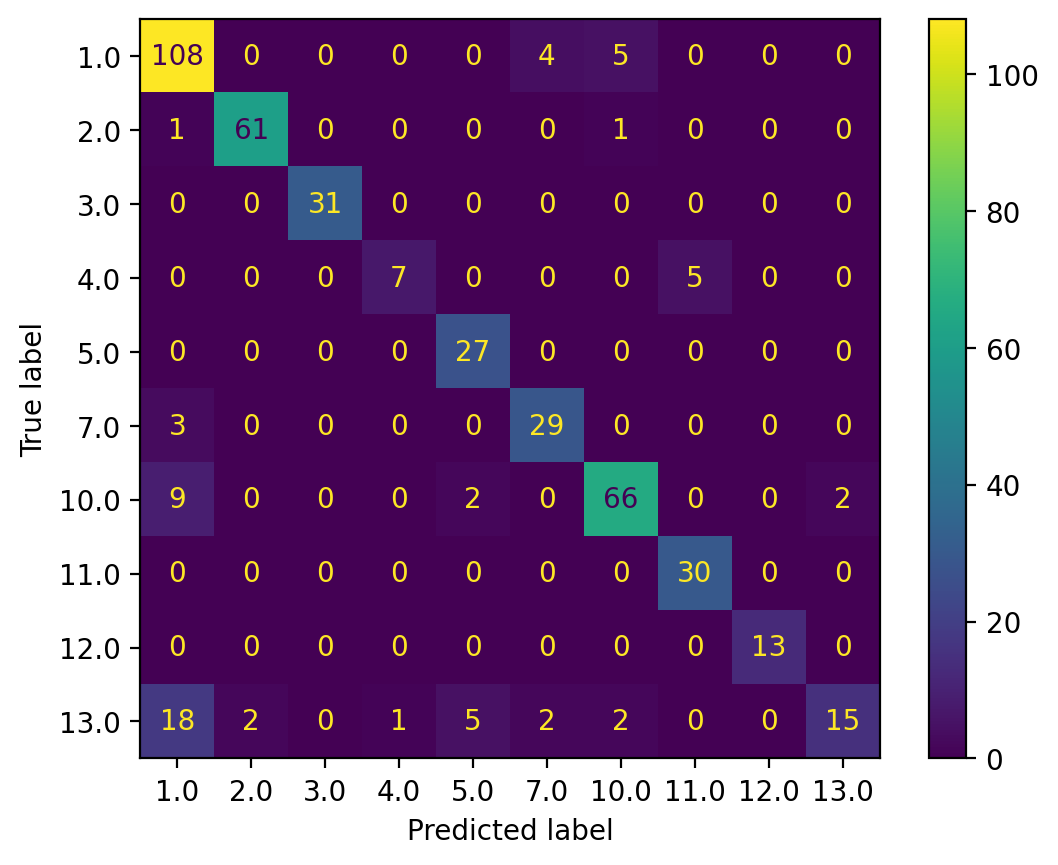

In [87]:
folds = 10
overlap = 0.5
sequence_length =256
best_params = None
label ="nawba"
random_state = 42
hyperparameter_tuning = False
print_results = True
skf = StratifiedKFold(n_splits=folds)
print(f"For [{label}]: Stride {overlap}% || Length of {sequence_length} notes", flush=True)
pred = []
actual = []
overall_acc = []
df, pitch_distr_sections, ql_distr_sections = prepare_dataframe(label, overlap, sequence_length)
prefixes, prefixes_y, prefix_to_ids = return_prefixes(df, label)        
    
for i, (train_index, test_index) in enumerate(skf.split(prefixes, prefixes_y)):
    print(f" {i},", end="", flush=True) 
    random.seed(random_state)
    np.random.seed(random_state)
    #train_prefixes, test_prefixes = train_test_split(prefixes, stratify=prefixes_y, test_size=0.2, random_state=random_state)
    train_prefixes = prefixes[train_index]
    test_prefixes= prefixes[test_index]
    # Step 3: Gather IDs for train and test sets
    train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]

    #compare_plot_label_distribution(df_windowed, df_notes)
    shuffled_df = df.sample(frac=1, random_state=random_state)
    # Group by 'section_id'
    grouped = shuffled_df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', label]]
    # Create an array for each group

    group_arrays = {section_id: group.values for section_id, group in grouped}
    sequences_features = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for key, values in group_arrays.items():
        if key in train_ids:
            X_train.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
            y_train.append((values[0][-1]))
        else:
            X_test.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
            y_test.append((values[0][-1]))

        sequences_features.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))


    sequences_features = [list(x.values()) for x in sequences_features]
    X_train = [list(x.values()) for x in X_train]
    X_test = [list(x.values()) for x in X_test]
    
    if hyperparameter_tuning and i == 0:
        clf = RandomForestClassifier()
        # Initialization of hyperparameter choice
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        max_features = ['sqrt', 'log2', None]
        criterion = ['gini', 'entropy', 'log_loss']
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        bootstrap = [True, False]
        random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'criterion': criterion,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

        rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 10, random_state=random_state, n_jobs = -1)
        rf_random.fit(X_train, y_train)
        best_params = rf_random.best_params_

    if hyperparameter_tuning and i > 0:
        clf = RandomForestClassifier(**best_params)
    if label == "nawba": 
        clf = RandomForestClassifier(n_estimators=800, random_state=random_state, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth = 70, bootstrap=False, criterion= 'gini', class_weight='balanced')
    else:
        clf = RandomForestClassifier(n_estimators=1200, random_state=random_state, min_samples_split=5, min_samples_leaf=2, max_features='log2', max_depth = 110, bootstrap=False, criterion= 'entropy', class_weight='balanced')
        
    clf.fit(X_train, y_train)
    pred.extend(clf.predict(X_test))
    actual.extend(y_test)
    overall_acc.append(clf.score(X_test, y_test))
    break

if print_results: 
    print(f"\n {'-' * 50}", flush=True) 
    print_performance(actual, pred , overall_acc)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

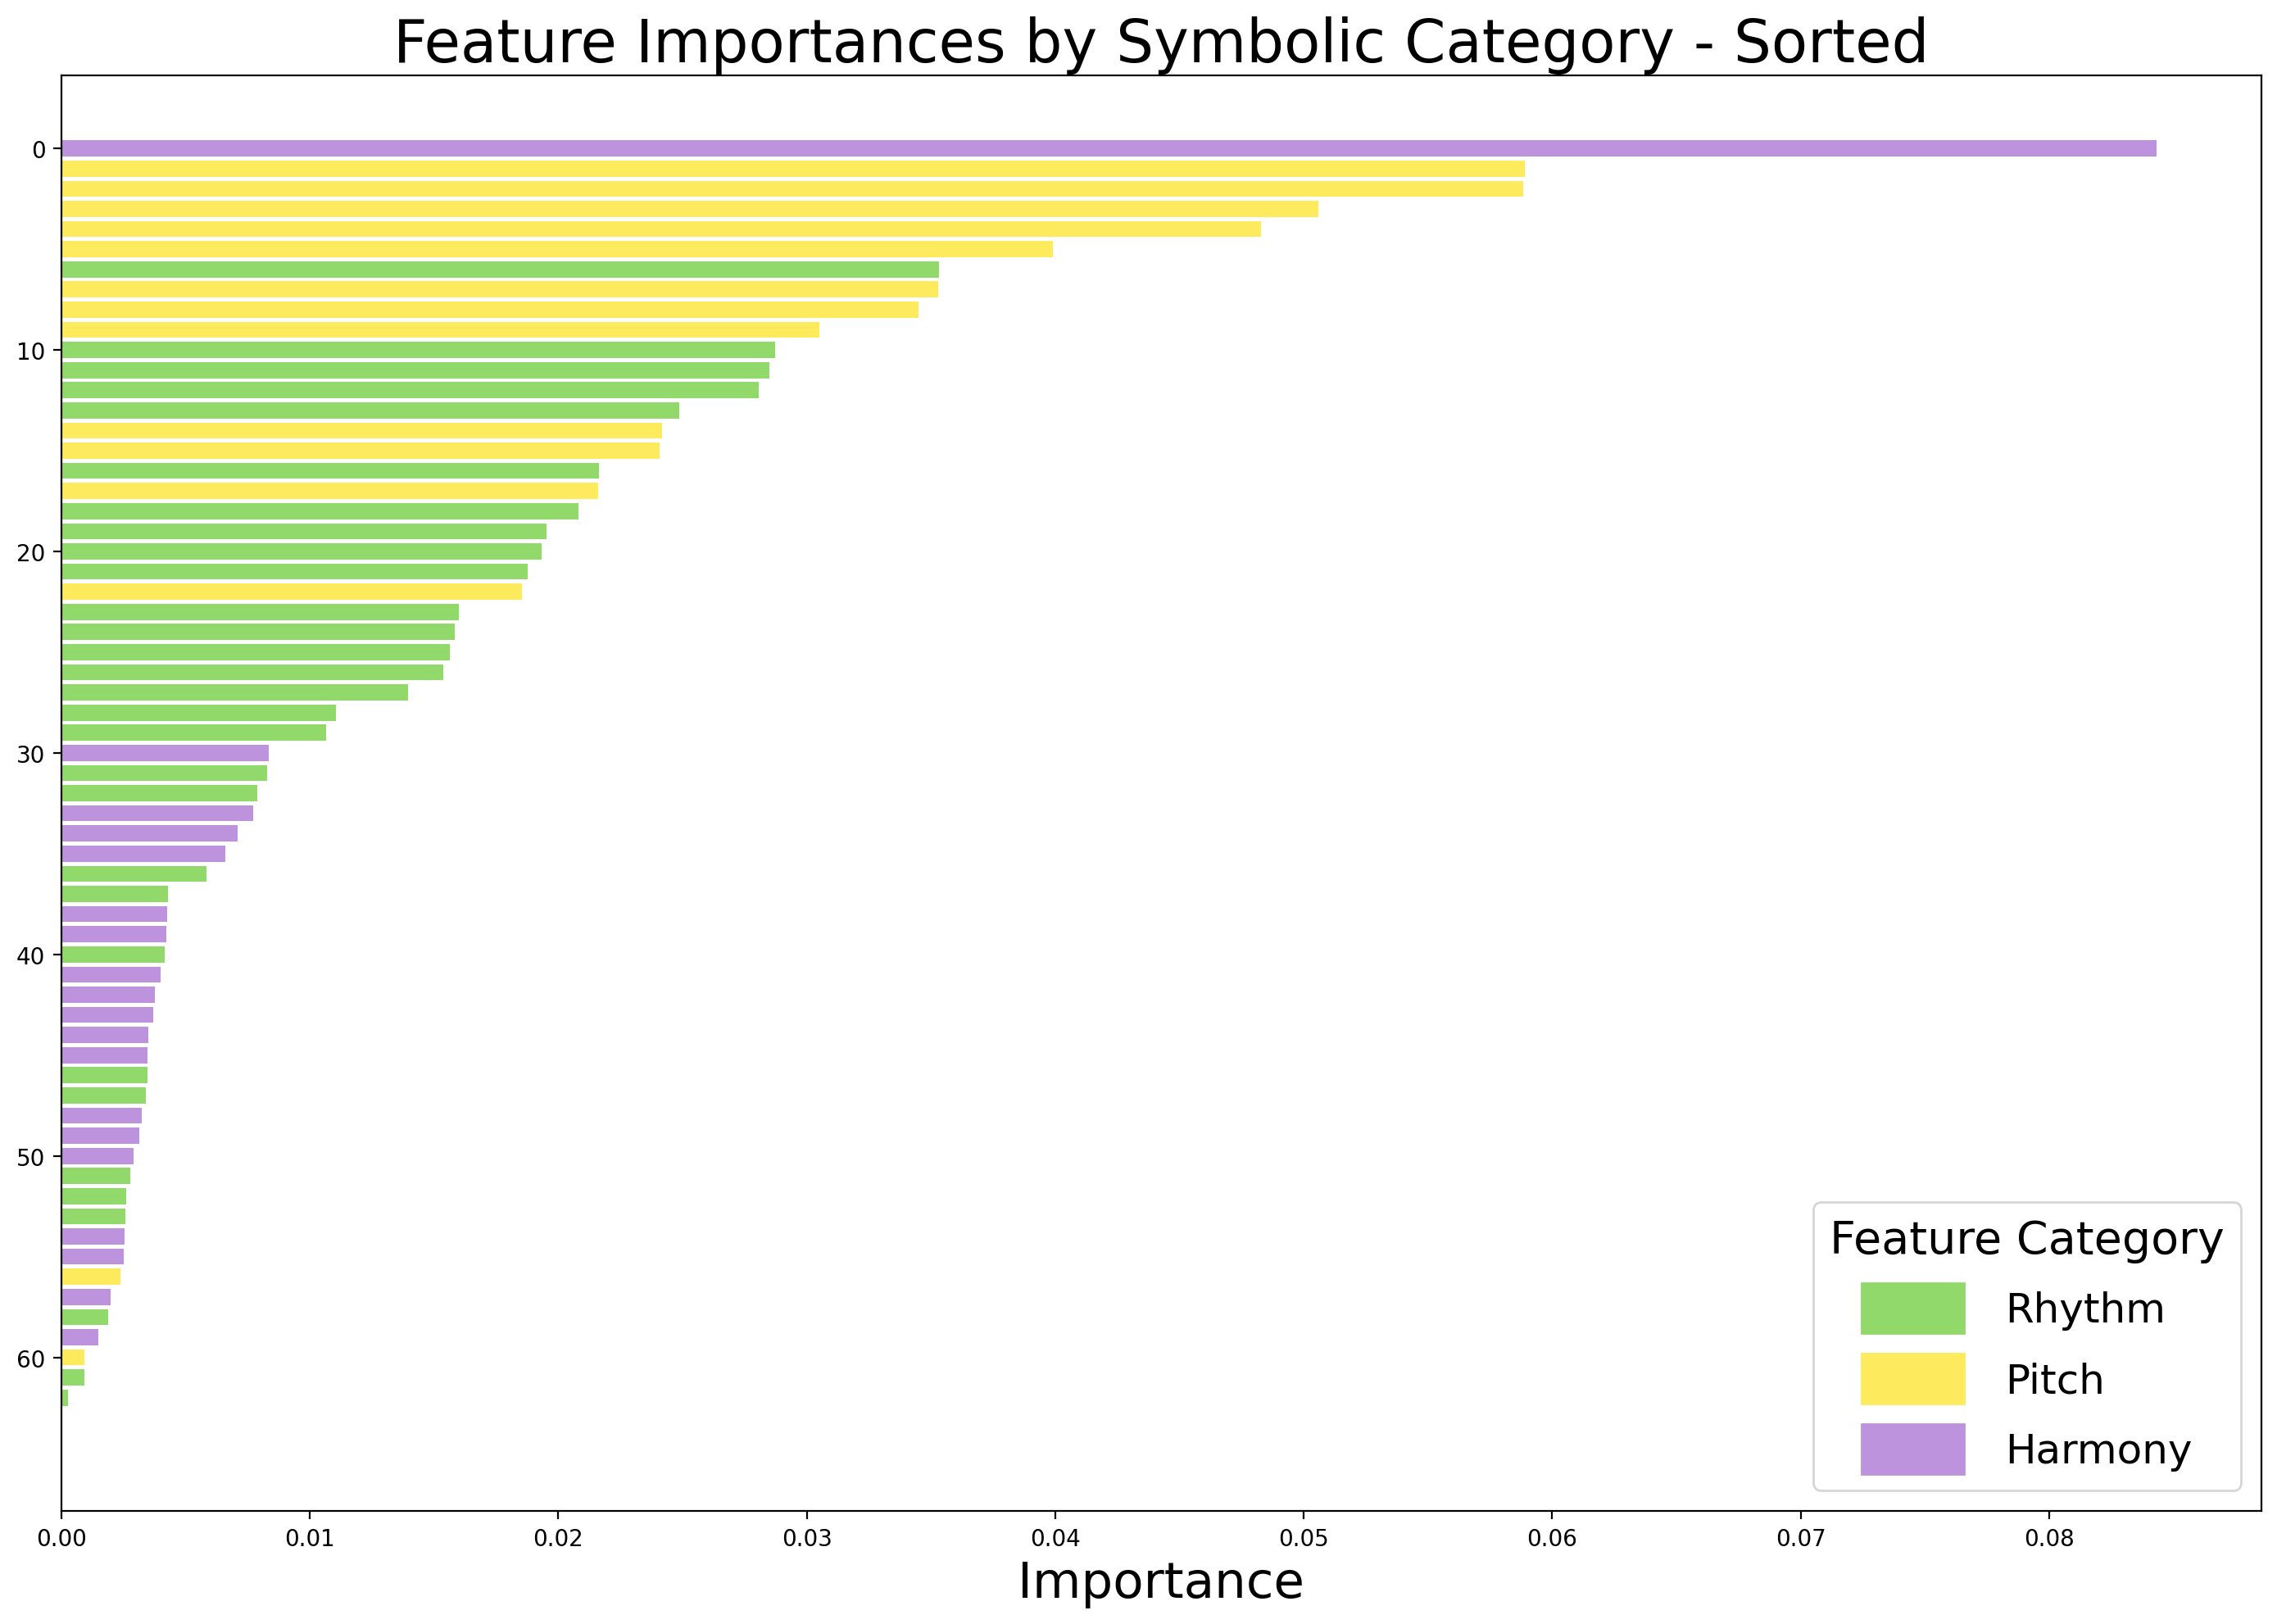

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.patches import Patch

# Set global font
#mpl.rcParams['font.family'] = 'Times New Roman'

feature_importances = np.array(clf.feature_importances_)
num_features = len(feature_importances)

# Define categories and index ranges
rhythm_indices = set([0] + list(range(3, 7)) + list(range(9, 19)) + list(range(31, 46)) + [63])
pitch_indices = set(list(range(1, 3)) + list(range(19, 31)) + [62])
harmony_indices = set(list(range(7, 9)) + list(range(46, 62)) + [64])

# Category colors
color_map = {
    "Rhythm": "#91d96a",
    "Pitch": "#fdea5d",
    "Harmony": "#be93de"
}

# Sort by importance descending
sorted_idx = np.argsort(feature_importances)[::-1]

# Assign colors
colors = []
for i in sorted_idx:
    if i in rhythm_indices:
        colors.append(color_map["Rhythm"])
    elif i in pitch_indices:
        colors.append(color_map["Pitch"])
    elif i in harmony_indices:
        colors.append(color_map["Harmony"])

# Labels with original index
labels = [f"Feat. {i}" for i in sorted_idx]

# Plot
plt.figure(figsize=(14, 10))
plt.barh(range(num_features), feature_importances[sorted_idx], color=colors)
#plt.yticks(range(num_features), labels, fontsize=18)
plt.xlabel("Importance", fontsize=22)
plt.title("Feature Importances by Symbolic Category - Sorted", fontsize=26)
plt.gca().invert_yaxis()

# Legend
legend_patches = [Patch(color=c, label=cat) for cat, c in color_map.items()]
plt.legend(handles=legend_patches, title="Feature Category",
           fontsize=18, title_fontsize=20, markerscale=2,
           handlelength=2.5, handleheight=1.5, handletextpad=1)

plt.tight_layout()
plt.show()


In [ ]:
df_notes = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')
df_notes['quarterLength'] = [0.33 if i == '1/3' else i for i in df_notes['quarterLength']]
df_notes['offset'] = [8/3 if i == '8/3' else i for i in df_notes['offset']]
df_notes['offset'] = [7/3 if i == '7/3' else i for i in df_notes['offset']]
slice = df_notes[df_notes['mizan'].isna()]
print(len(df_notes['quarterLength']))
print(len(slice))
df_notes['tie'] = df_notes['tie'].fillna(-1)
df = df_notes

for note in df['NoteAndRest'].unique():

    print(note, (len(df[df['NoteAndRest'] == note]['NoteAndRest'])/len(df['NoteAndRest'])) * 100, df[df['NoteAndRest'] == note]['quarterLength'].mean() )
    print(note, (len(slice[slice['NoteAndRest'] == note]['NoteAndRest'])/len(slice['NoteAndRest'])) * 100 , slice[slice['NoteAndRest'] == note]['quarterLength'].mean() )



769352
41747
A4 8.67119341991702 0.6458675350761482
A4 9.073705895034374 0.6944957761351637
Rest 13.086727531740996 0.7568668494184718
Rest 18.961841569454094 2.321390222334512
G4 14.465030311222952 0.6708015311761482
G4 12.808105971686587 0.7101178230783617
F4 12.05728977113207 0.5805519442018909
F4 13.94351689941792 0.6312489263013228
E4 15.803429379529785 0.6065035284247927
E4 14.590269959518048 0.6394885897225414
D4 12.241600723725941 0.6551016128518491
D4 11.469087599108917 0.7153560985797828
C4 9.884292235543677 0.6396196331119732
C4 8.810213907586174 0.6870241979336597
B-4 0.5291466064948164 0.4463890935887988
B-4 0.5293793566004743 0.47737556561085975
B3 2.8985431895933202 0.6070964125560538
B3 2.098354372769301 0.6503995433789954
B4 2.680177604009608 0.6412584869059166
B4 1.882770019402592 0.6463104325699746
C5 2.1798864498954966 0.649931429252877
C5 2.1342850983304187 0.6481481481481481
D5 1.0439954663145088 0.7368494770916335
D5 1.0443864229765014 0.6680045871559633
F#4 1.44

77
Precision Micro: 0.753247
Precision Macro: 0.789177


Precision Weighted: 0.789177
Recall Macro: 0.753247
Recall Micro: 0.753247
Recall Weighted: 0.753247
F1 score Weighted: 0.742721
F1 score Macro: 0.742721
F1 score Micro: 0.753247


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

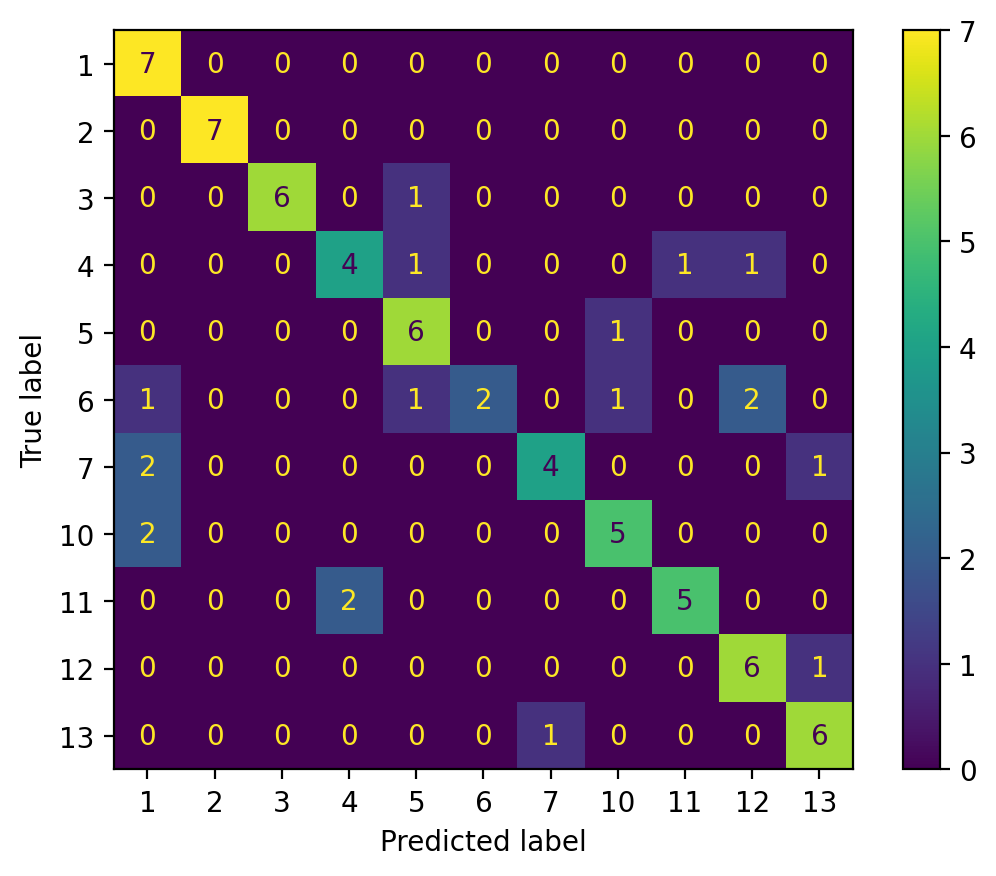

In [95]:
actual = [1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4,5,5,5,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,7,7,7,10,10,10,10,10,10,10,11,11,11,11,11,11,11,12,12,12,12,12,12,12,13,13,13,13,13,13,13]
pred =   [1,1,1,1,1,1,1
         ,2,2,2,2,2,2,2
         ,3,3,3,3,3,3,5,
         4,4,4,4,5,11,12
         ,5,5,5,5,5,5,10,
         1
         ,5,6,6,10,12,12,1
         ,1,7,7,7,7,13,1
         ,1,10,10,10,10,10,4
         ,4,11,11,11,11,11,12
         ,12,12,12,12,12,13,7
         ,13,13,13,13,13,13]
print(len(pred))
print_performance(actual, pred)

In [ ]:
#tab 128
rec = [0.982759,
1.000000,
0.916667,
0.846154,
0.914894,
0.913793,
0.958333,
0.750000,
0.822222,
1.000000]
prec = [
0.983953,
1.000000,
0.923077,
0.858156,
0.856322,
0.966667,
0.666667,
0.762963,
1.000000,
0.861111]
f1 = [
0.982753,
1.000000,
0.883333,
0.846154,
0.880851,
0.879310,
0.956481,
0.700000,
0.786667,
1.000000]

print(np.array(prec).mean())
print(np.array(rec).mean())
print(np.array(f1).mean())


0.8878915999999999
0.9104822
0.8915549


In [ ]:
#tab 256
prec = [0.988057,
0.936832,
0.869792,
0.908759,
0.787686,
0.888535,
0.795635,
0.662500,
0.671053,
1.000000]

rec = [0.987261,
0.938776,
0.906250,
0.817518,
0.808917,
0.936306,
0.861111,
0.750000,
0.736842,
1.000000]

f1 = [0.986888,
0.931973,
0.879464,
0.817518,
0.796178,
0.909008,
0.822650,
0.694444,
0.692982,
1.000000]





micro = [0.987261,
0.938776,
0.906250,
0.817518,
0.808917,
0.936306,
0.861111,
0.750000,
0.736842,
1.000000]

print(np.array(prec).mean())
print(np.array(rec).mean())
print(np.array(f1).mean())


0.8508848999999998
0.8742981000000001
0.8531105
0.8742981000000001


In [ ]:

#nawba 128
prec = [0.937984,
0.884615,
0.817949,
0.744762,
0.826923,
0.903547,
0.815774,
1.000000,
0.964286,
0.973298]

rec= [0.917308,
0.923077,
0.826923,
0.760000,
0.884615,
0.841071,
0.885185,
1.000000,
0.928571,
0.962617]

f1 = [0.912450,
0.897436,
0.799145,
0.727030,
0.846154,
0.836104,
0.842991,
1.000000,
0.928571,
0.962856]


print(np.array(prec).mean())
print(np.array(rec).mean())
print(np.array(f1).mean())


0.8869138
0.8929366999999999
0.8752736999999999


In [ ]:

# nawba 256
prec = [0.953094,
0.911765,
0.837666,
0.785205,
0.720329,
0.910526,
0.914634,
0.994118,
0.883333,
0.983398]

rec = [0.934722,
0.941176,
0.823684,
0.771429,
0.759722,
0.842105,
0.920732,
0.993750,
0.850000,
0.978417]

f1 = [0.934448,
0.921569,
0.804921,
0.746307,
0.707735,
0.841228,
0.913778,
0.993636,
0.830000,
0.979097]

print(np.array(prec).mean())
print(np.array(rec).mean())
print(np.array(f1).mean())


0.8894067999999999
0.8815737
0.8672718999999999


In [47]:
slice.columns

Index(['NoteAndRest', 'timestamp_(scs)', 'measure_number', 'quarterLength',
       'bpm', 'beatStrength', 'offset', 'tie', 'isChord', 'mizan', 'form',
       'nawba', 'tab', 'section_id', 'key'],
      dtype='object')


=== REST FREQUENCY COMPARISON ===
Full corpus: 13.09% rests (100,683 of 769,352 notes)
Excluded slice: 18.96% rests (7,916 of 41,747 notes)
Slice contains 7.86% of all rests

=== REST DURATION ANALYSIS ===
Full corpus rest durations:
count    100683.000000
mean          0.756867
std           1.051405
min           0.125000
25%           0.500000
50%           0.500000
75%           0.500000
max          12.000000
Name: quarterLength, dtype: float64

Excluded slice rest durations:
count    7916.000000
mean        2.321390
std         2.741055
min         0.250000
25%         0.500000
50%         0.500000
75%         3.000000
max        12.000000
Name: quarterLength, dtype: float64

=== MEASURE BOUNDARY ANALYSIS ===
Found 3756 rests at measure boundaries
Boundary rest durations:
count    3756.000000
mean        4.310437
std         2.872057
min         0.250000
25%         1.000000
50%         3.000000
75%         8.000000
max        12.000000
Name: quarterLength, dtype: float64

=== B

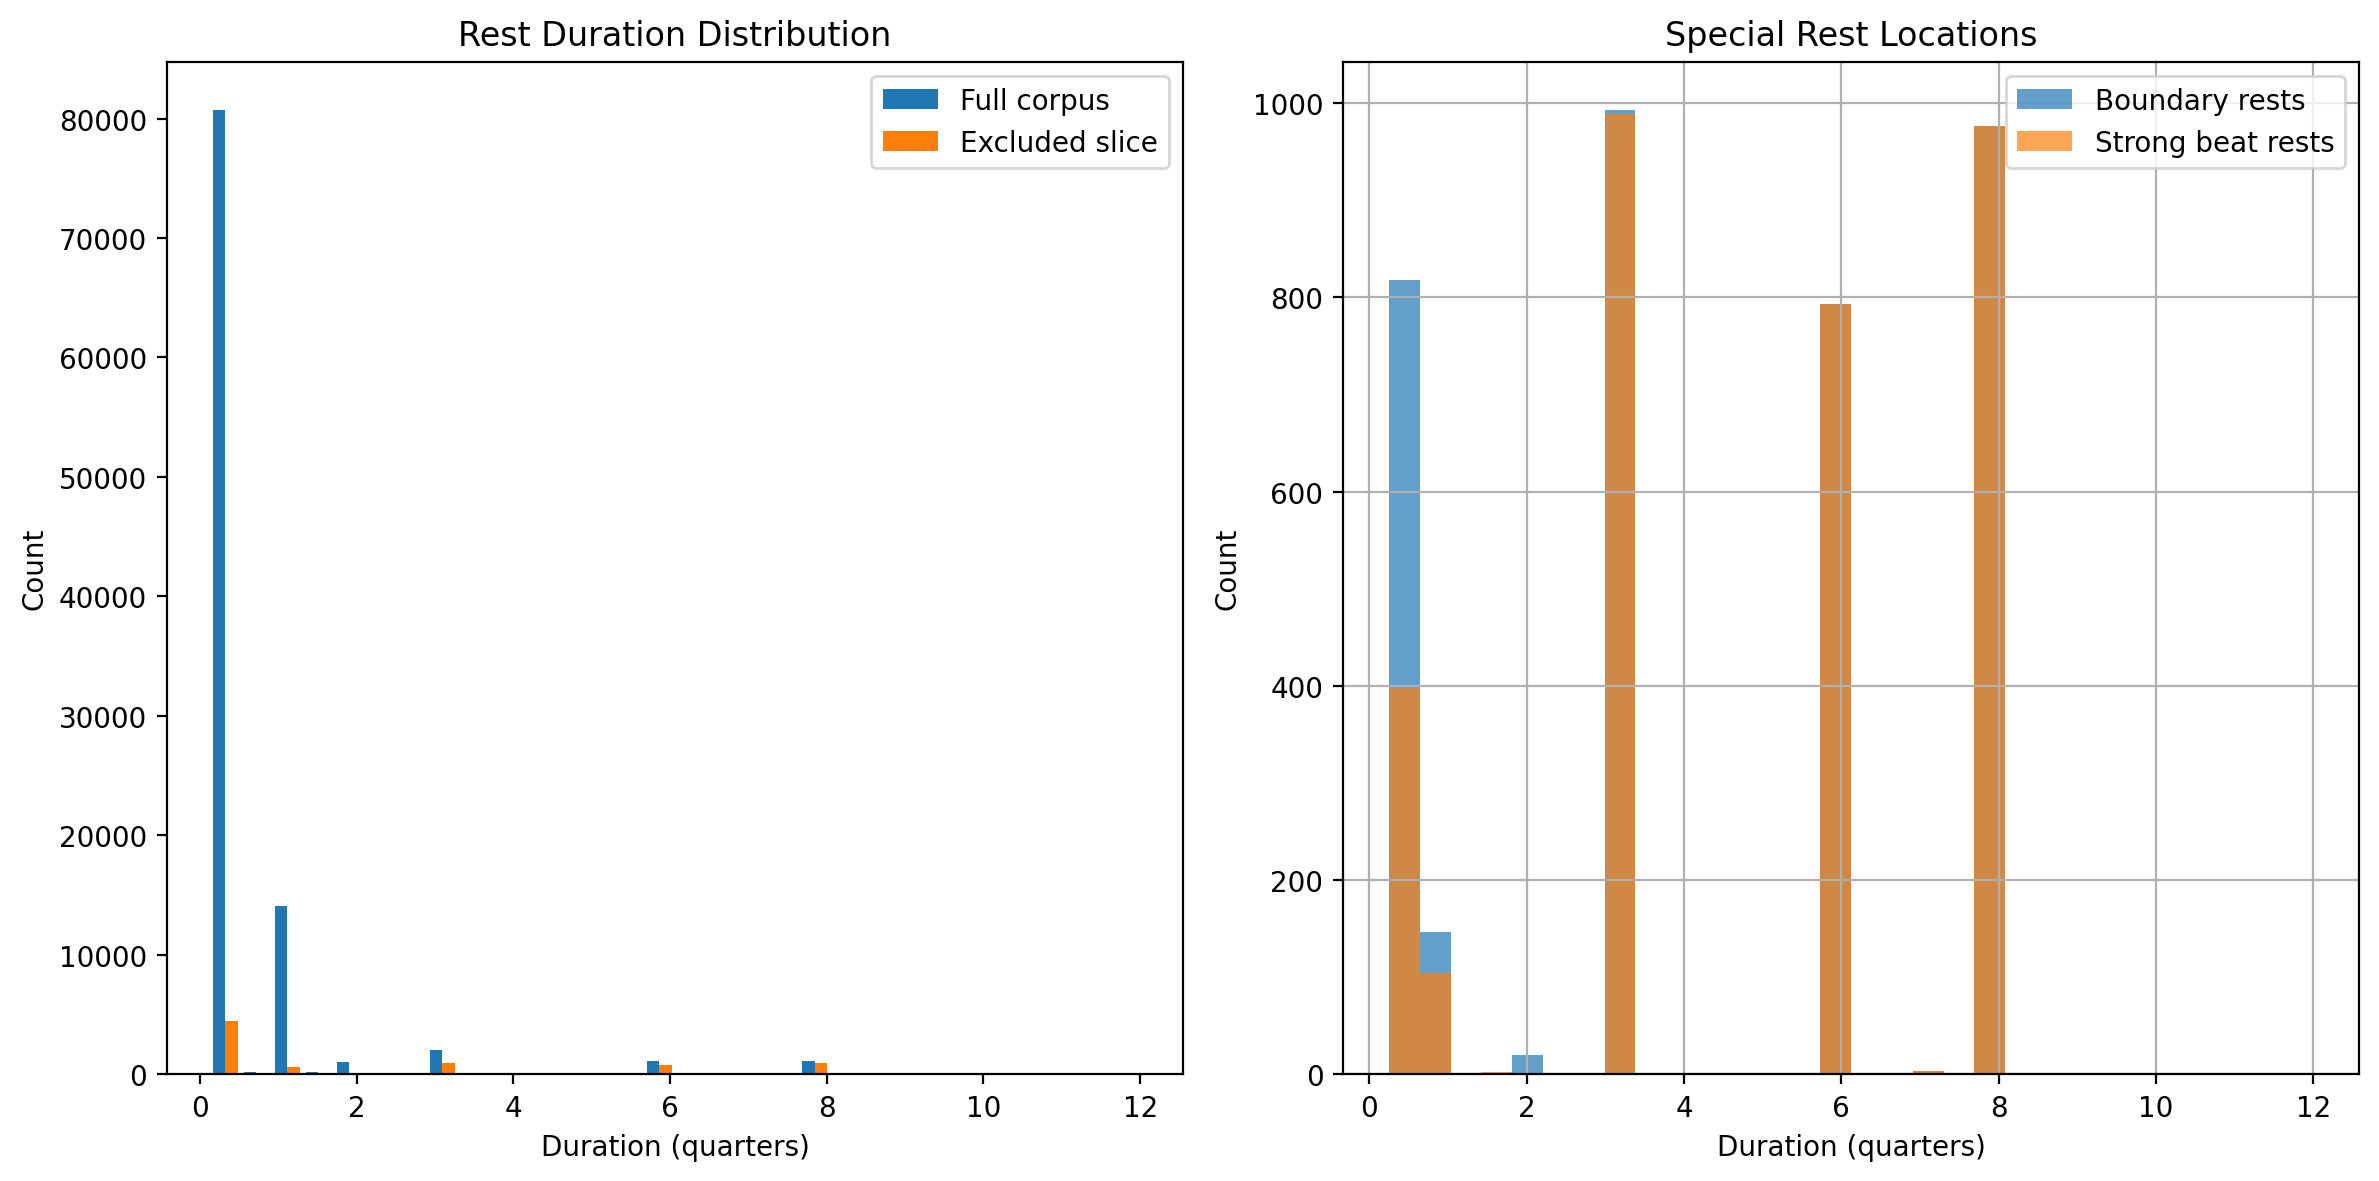


=== COMBINED INSIGHTS ===

Characteristics of long rests (>1.5 quarters):
- On measure boundaries: 99.72%
- On strong beats: 98.47%
- Both: 98.47%


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df_notes = pd.read_json('note_corpus3.json', orient='split', compression='infer')

# Preprocess columns (as you showed earlier)
df_notes['quarterLength'] = [0.33 if i == '1/3' else i for i in df_notes['quarterLength']]
df_notes['offset'] = [8/3 if i == '8/3' else i for i in df_notes['offset']]
df_notes['offset'] = [7/3 if i == '7/3' else i for i in df_notes['offset']]
df_notes['tie'] = df_notes['tie'].fillna(-1)

# Create the slice with missing mizan
slice = df_notes[df_notes['mizan'].isna()]

# 1. Basic Rest Statistics Comparison
print("\n=== REST FREQUENCY COMPARISON ===")
total_notes = len(df_notes)
slice_notes = len(slice)
total_rests = len(df_notes[df_notes['NoteAndRest'] == 'Rest'])
slice_rests = len(slice[slice['NoteAndRest'] == 'Rest'])

print(f"Full corpus: {total_rests/total_notes:.2%} rests ({total_rests:,} of {total_notes:,} notes)")
print(f"Excluded slice: {slice_rests/slice_notes:.2%} rests ({slice_rests:,} of {slice_notes:,} notes)")
print(f"Slice contains {slice_rests/total_rests:.2%} of all rests")

# 2. Duration Analysis
print("\n=== REST DURATION ANALYSIS ===")
print("Full corpus rest durations:")
print(df_notes[df_notes['NoteAndRest'] == 'Rest']['quarterLength'].describe())
print("\nExcluded slice rest durations:")
print(slice[slice['NoteAndRest'] == 'Rest']['quarterLength'].describe())

# 3. Detect Measure Boundaries (using measure_number)
print("\n=== MEASURE BOUNDARY ANALYSIS ===")
# Create a shifted measure number column to detect boundaries
slice_sorted = slice.sort_values(['section_id', 'measure_number', 'offset'])
slice_sorted['next_measure'] = slice_sorted.groupby('section_id')['measure_number'].shift(-1)
slice_sorted['is_boundary'] = slice_sorted['next_measure'] != slice_sorted['measure_number']

# Analyze rests at boundaries
boundary_rests = slice_sorted[(slice_sorted['NoteAndRest'] == 'Rest') & 
                             (slice_sorted['is_boundary'])]
print(f"Found {len(boundary_rests)} rests at measure boundaries")
print("Boundary rest durations:")
print(boundary_rests['quarterLength'].describe())

# 4. Beat Strength Analysis
print("\n=== BEAT STRENGTH ANALYSIS ===")
slice['strong_beat'] = slice['beatStrength'] > 0.7  # Adjust threshold as needed
strong_beat_rests = slice[(slice['NoteAndRest'] == 'Rest') & 
                         (slice['strong_beat'])]
print(f"Found {len(strong_beat_rests)} rests on strong beats")
print("Strong beat rest durations:")
print(strong_beat_rests['quarterLength'].describe())

# 5. Offset Pattern Analysis
print("\n=== OFFSET PATTERN ANALYSIS ===")
slice['offset_rounded'] = slice['offset'].round(2)
rest_offset_patterns = slice[slice['NoteAndRest'] == 'Rest'].groupby('offset_rounded').size().sort_values(ascending=False)
print("Most common rest positions:")
print(rest_offset_patterns.head(10))

# 6. Visualization
print("\n=== VISUALIZATION ===")
plt.figure(figsize=(12, 6))

# Duration distribution
plt.subplot(1, 2, 1)
plt.hist([df_notes[df_notes['NoteAndRest'] == 'Rest']['quarterLength'],
          slice[slice['NoteAndRest'] == 'Rest']['quarterLength']],
          bins=30, label=['Full corpus', 'Excluded slice'])
plt.title('Rest Duration Distribution')
plt.xlabel('Duration (quarters)')
plt.ylabel('Count')
plt.legend()

# Position analysis
plt.subplot(1, 2, 2)
boundary_rests['quarterLength'].hist(bins=30, alpha=0.7, label='Boundary rests')
strong_beat_rests['quarterLength'].hist(bins=30, alpha=0.7, label='Strong beat rests')
plt.title('Special Rest Locations')
plt.xlabel('Duration (quarters)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Combined Insights
print("\n=== COMBINED INSIGHTS ===")
slice['long_rest'] = (slice['NoteAndRest'] == 'Rest') & (slice['quarterLength'] > 1.5)
special_rests = slice[slice['long_rest']].copy()
special_rests['boundary'] = special_rests['offset'].round(2).isin(rest_offset_patterns.head(5).index)
special_rests['strong_beat'] = special_rests['beatStrength'] > 0.7

print("\nCharacteristics of long rests (>1.5 quarters):")
print(f"- On measure boundaries: {special_rests['boundary'].mean():.2%}")
print(f"- On strong beats: {special_rests['strong_beat'].mean():.2%}")
print(f"- Both: {(special_rests['boundary'] & special_rests['strong_beat']).mean():.2%}")

In [2]:
from utilities.model_matching_computation import *
all_tracks_id = []
for track in get_all_id_tracks():
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if os.path.exists(path):
            all_tracks_id.append(track)
df = pd.DataFrame({
    'track_id': all_tracks_id,
    'nawba': get_id_label('nawba')
    })
df = df.dropna()
df = df[df['nawba'].isin(NAWBA_LIST_TRAIN)]
#df = df[df['track_id'] != '0386e377-7212-43e5-89b6-7f4c42d0ae74']
#df.info()
df_notes = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')

df_notes['track_id'] = df_notes['section_id'].str[:PREFIX_LENGTH]

df_notes['tie'] = df_notes['tie'].fillna(-1)
df_notes = df_notes.dropna()
df = parse_all_tracks_sections()
df['tab'] = df['tab'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df['nawba'] = df['nawba'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df['mizan'] = df['mizan'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df


,start_time,tab,nawba,end_time,form,mizan,023b4a37-1ab4-4593-b03a-850ee0db8350mizan,track_id
0,00:00:03,16,11,00:01:36,"{'id': 17, 'name': 'المشالية', 'transliterated...",1.0,NaN,2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
1,00:01:37,16,11,00:05:16,"{'id': 26, 'name': 'توشية النوبة', 'transliter...",2.0,NaN,2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
2,00:05:17,16,11,00:13:37,"{'id': 21, 'name': 'الموسع', 'transliterated_n...",NaN,"{'id': 2, 'name': 'بسيط', 'transliterated_name...",2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
3,00:13:38,16,11,00:27:28,"{'id': 18, 'name': 'المهزوز', 'transliterated_...",2.0,NaN,2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
4,00:27:29,16,11,00:31:18,"{'id': 1, 'name': 'إنشاد', 'transliterated_nam...",2.0,NaN,2d91d7e4-904a-46b7-bce2-230ca4e1b1c4
...,...,...,...,...,...,...,...,...
842,00:00:00,1,1,00:02:20,"{'id': 17, 'name': 'المشالية', 'transliterated...",1.0,NaN,023b4a37-1ab4-4593-b03a-850ee0db8350
843,00:02:21,1,1,00:05:50,"{'id': 24, 'name': 'توشية الميزان', 'translite...",10.0,NaN,023b4a37-1ab4-4593-b03a-850ee0db8350
844,00:05:50,1,1,00:33:26,"{'id': 21, 'name': 'الموسع', 'transliterated_n...",10.0,NaN,023b4a37-1ab4-4593-b03a-850ee0db8350
845,00:33:27,1,1,01:29:47,"{'id': 18, 'name': 'المهزوز', 'transliterated_...",10.0,NaN,023b4a37-1ab4-4593-b03a-850ee0db8350


In [2]:
def skf_template_rhythm_matching(label, df, df_notes, std, split, rn):
    """
    Parameters:
        df: dataframe with section id and target label
        df_notes: General note json stored in note_corpus{i}.json
        std: standard deviation value to compute gaussina smoothening with
        split: how many folds to perform
    -------------------------------------------------------------------

    Perfoms the model matching experiment by splitting the dataset into sections of tracks.
    Computes histogram into models and then compares it to each comprehensive target label model.
    """
    df = df[df[label].isin(LABEL_LIST_TRAIN[label])]
    X = df.filter(['track_id', label])
    y = df.filter([label])
    
    mizan_models = []
    overall_acc = []
    actual = []
    predicted = []
    
    for i in range(split):
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state= i * rn)
    
        for mizan in LABEL_LIST_TRAIN[label]:
            
            ql = df_notes[(df_notes[label] == mizan) & 
                                    (df_notes['track_id'].isin(X_train['track_id'].tolist()))
                                    ]['quarterLength'].tolist()
            
            hist_y_avg = get_folded_rhythm_histogram(ql)
            _, y_model = convert_folded_scores_in_models_rythm([hist_y_avg], std)
            mizan_models.append(y_model[0])
            
            test_models = []
            curr_acc = []
        for j in range(len(X_test)):    
            ql = df_notes[df_notes['track_id'] == X_test['track_id'].iloc[j]]['quarterLength'].tolist()
            hist_y_avg = get_folded_rhythm_histogram(ql)
            
            _, y_model_test = convert_folded_scores_in_models_rythm([hist_y_avg], std)
            test_models.append(y_model_test[0])
            label_score = []
            for l, label_t2 in enumerate(MIZAN_LIST_TRAIN):
                label_score.append((get_distance(y_model_test[0], mizan_models[l], 'L2'), label_t2))
            curr_acc.append(y_test.iloc[j][label] == min(label_score)[1])
            
            actual.append(y_test.iloc[j][label])
            predicted.append(min(label_score)[1])
        overall_acc.append(sum(curr_acc) / len(curr_acc))
        
    return actual, predicted, overall_acc, mizan_models

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def skf_model_matching(label, df, random_state, k, std):
    """
    Parameters:
        df: dataframe with 'track_id' and target label
        std: standard deviation for Gaussian smoothing
        label: label column name in the dataframe
        k: number of folds for cross-validation
    -------------------------------------------------------------------
    Performs model matching experiment with proper Stratified K-Fold.
    """

    X = df[['track_id', label]]
    y = df[label]

    overall_acc = []
    actual = []
    predicted = []

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # CREATE TEMPLATES FOR EACH LABEL FROM TRAINING DATA
        y_model_list = []
        for label_t in LABEL_LIST_TRAIN[label]:
            train_tracks = X_train[X_train[label] == label_t]['track_id'].tolist()
            _, y_temp = compute_avg_folded_hist_scores(train_tracks)
            _, y_model = convert_folded_scores_in_models([y_temp], std)
            y_model_list.append(y_model[0])

        # EVALUATE ON TEST DATA
        curr_acc = []
        for i in range(len(X_test)):
            track_id = X_test.iloc[i]['track_id']
            _, y_temp = compute_avg_folded_hist_scores([track_id])
            _, y_model_test = convert_folded_scores_in_models([y_temp], std)

            # Compute distance to each label model
            label_scores = [
                (get_distance(y_model_test[0], model, 'L2'), label_name)
                for model, label_name in zip(y_model_list, LABEL_LIST_TRAIN[label])
            ]
            predicted_label = min(label_scores)[1]
            true_label = y_test.iloc[i]

            curr_acc.append(true_label == predicted_label)
            actual.append(true_label)
            predicted.append(predicted_label)

        overall_acc.append(np.mean(curr_acc))

    return actual, predicted, overall_acc


In [ ]:
# PREPARE DATASET FOR TRAINING 
all_tracks_id = []
for track in get_all_id_tracks():
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if os.path.exists(path):
            all_tracks_id.append(track)
df = pd.DataFrame({
    'track_id': all_tracks_id,
    'tab': get_id_label('tab')
    })

df = df[df['tab'].isin(TAB_LIST_TRAIN)]
#df.info()
actual = []
pred = []
overall_acc = []
y_test, y_pred, overall_acc = skf_model_matching('tab', df, random_state= 42, k= 10, std=30)
print_performance(y_test, y_pred, overall_acc)

In [5]:
# PREPARE DATASET FOR TRAINING 
all_tracks_id = []
for track in get_all_id_tracks():
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if os.path.exists(path):
            all_tracks_id.append(track)
df = pd.DataFrame({
    'track_id': all_tracks_id,
    'nawba': get_id_label('nawba')
    })

df = df[df['nawba'].isin(NAWBA_LIST_TRAIN)]
#df.info()
actual = []
pred = []
overall_acc = []
y_test, y_pred, overall_acc = skf_model_matching('nawba', df, random_state= 42, k= 10, std=30)
print_performance(y_test, y_pred, overall_acc)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

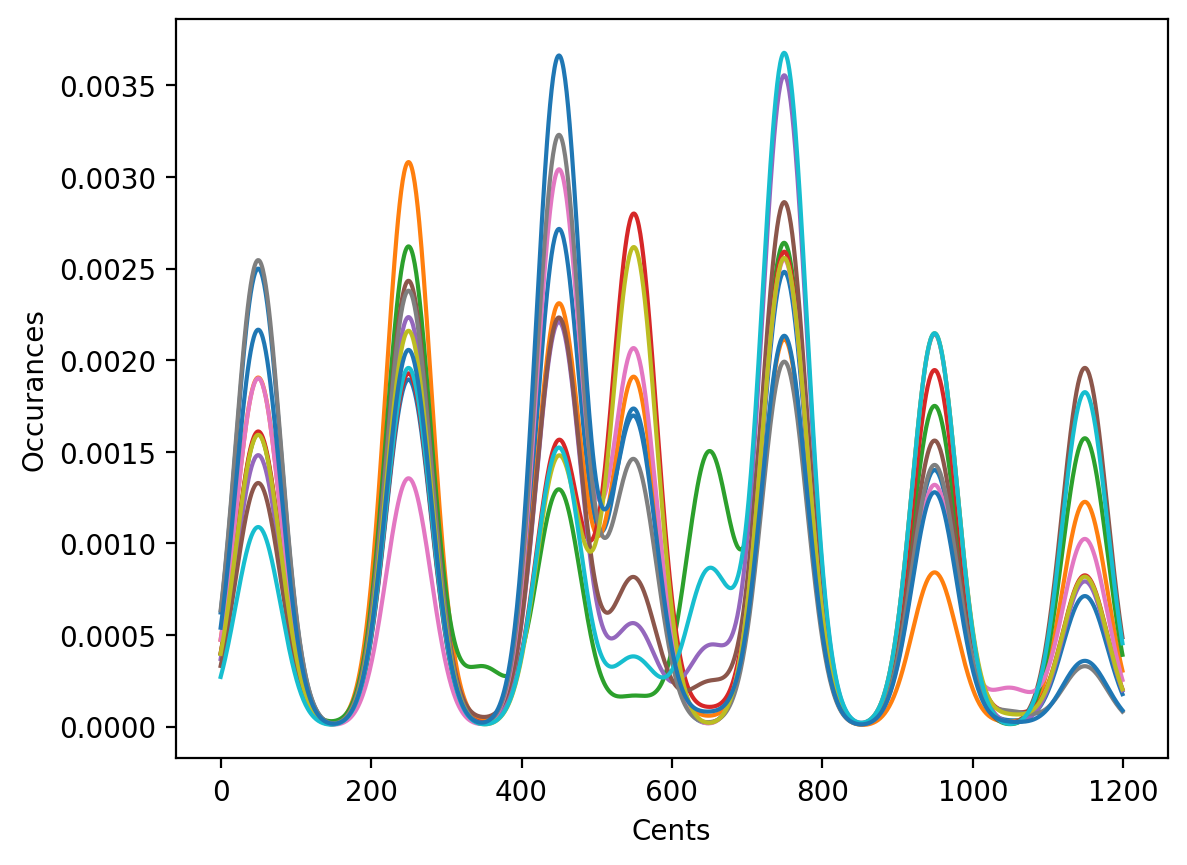

In [4]:
for model in models:
    plt.xlabel("Cents")
    plt.ylabel("Occurances")
    plt.plot(model)

For [tab]: Stride 0.5% || Length of 1024 notes
Done with fold:  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 --------------------
Precision: 0.851100
Std. Deviation: 0.0697
Weighted recall for each class: 0.808353
Global recall: 0.851100
F1 score: 0.851100


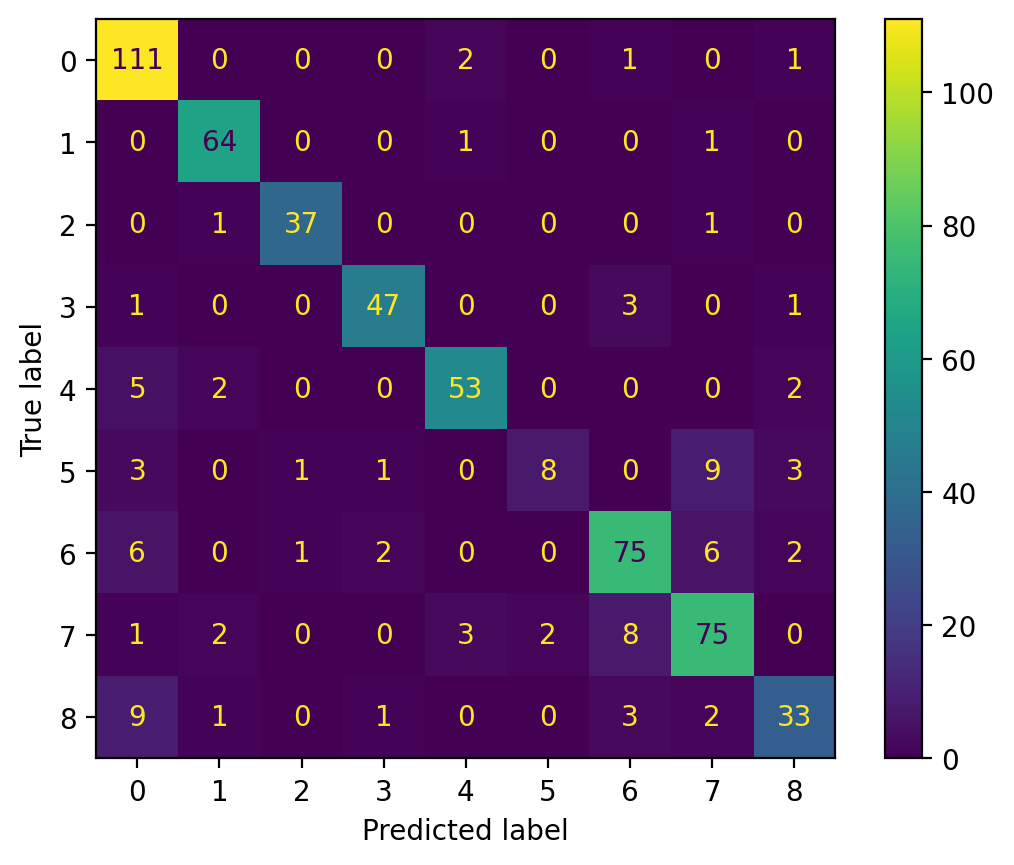

In [ ]:
from sklearn import svm
label = "tab"
overlap = 0.5
sequence_length= 1024
random_state = 42
folds = 10
print_results = True
print(f"For [{label}]: Stride {overlap}% || Length of {sequence_length} notes", flush=True)
random.seed(random_state)
np.random.seed(random_state)
df, pitch_distr_sections, ql_distr_sections = prepare_dataframe(label, overlap, sequence_length)
prefixes, prefixes_y, prefix_to_ids = return_prefixes(df, label)
df_windowed = normalize_and_traspose(df, label, pitch_distr_sections, ql_distr_sections)
skf = StratifiedKFold(n_splits=folds)
prefixes = np.array(prefixes)
actual = []
pred = []
overall_acc = []
print(f"Done with fold: ", end="", flush=True)
for i, (train_index, test_index) in enumerate(skf.split(prefixes, prefixes_y)):
    print(f" {i},", end="", flush=True)
    #train_prefixes, test_prefixes = train_test_split(prefixes, stratify=prefixes_y, test_size=0.2, random_state=random_state)
    
    train_prefixes = prefixes[train_index]
    test_prefixes= prefixes[test_index]

    # Step 3: Gather IDs for train and test sets
    train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]
    test_ids = [id_ for prefix in test_prefixes for id_ in prefix_to_ids[prefix]]

    
    X_train, y_train = df_windowed[df_windowed['section_id'].isin(train_ids)]['global_features'], df_windowed[df_windowed['section_id'].isin(train_ids)][label].tolist()
    X_test, y_test = df_windowed[df_windowed['section_id'].isin(test_ids)]['global_features'], df_windowed[df_windowed['section_id'].isin(test_ids)][label].tolist()    
    
    # Stack features
    global_train = np.vstack(X_train.to_numpy())
    global_test = np.vstack(X_test.to_numpy())

    # Fit scaler on all columns except last
    scaler = StandardScaler().fit(global_train[:, :-1])

    # Transform and reattach last column
    X_train = list(np.hstack([scaler.transform(global_train[:, :-1]), global_train[:, -1:]]))
    X_test = list(np.hstack([scaler.transform(global_test[:, :-1]), global_test[:, -1:]]))

    
    clf = svm.SVC(C=1e5, kernel = 'rbf',max_iter=50000, class_weight='balanced')
    clf.fit(X_train, y_train)
    actual.extend(y_test)
    pred.extend(clf.predict(X_test)) 
    overall_acc.append(clf.score(X_test, y_test))

    # Check if it converged and the testing accuracy
    #print("testing accuracy:", clf.score(X_test, y_test), flush=True)
if print_results: 
    print(f"\n {'-' * 20}", flush=True) 
    print_performance(actual, pred , overall_acc)

In [4]:
run_RNN_experiment_k("tab", 0.5, 1024, 4, 128,42, batch_size=16)

For [tab]: Stride 0.5% || Length of 1024 notes

--- Fold 1/10 ---


KeyboardInterrupt: 

679856bc-132f-4982-b04e-cbf6b5b1129b
161.75
9727ddbe-eb79-461b-9861-8a60336b17f6
334.5
92de6fc8-a040-4500-bd94-73e9ee39f189
502.75
a1eac726-208e-4c24-bd57-e34e9e93dcd3


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a0e3e4ecdf0>>
Traceback (most recent call last):
  File "/home/ale/miniconda3/envs/pyg-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


699.25
b3d92934-0946-4f2d-8183-312450d7e45e
898.5
44183247-4857-40cd-82bc-b4e9e3f458f1
937.0
023b4a37-1ab4-4593-b03a-850ee0db8350
1336.5
f461045b-50bc-4b20-a731-66fbd3a264ae
1567.0
4342021d-03a1-4727-8c0f-3c23180ef374
1654.25
3e5a82a2-d806-45cc-876e-6fa8a2b5a61d
1692.75
e3003cd0-430a-4481-a33d-c15c22da2404
1899.0
d4cadf34-1074-44ce-9928-f438198d5d6d
1925.25
97223154-d5c2-4c37-8e6c-4c998056a674
1925.25
2d2683c4-4b3e-4430-a254-c828427bdcc7
1956.25
e22549ae-4a0c-43ef-87f4-e0f81ed49d58
2175.0
91d6a3f1-07c3-49b2-bcea-7d6c378e73cd
2175.0
cb85269e-ab6c-4226-aea1-8226be1fe86c
2383.25
5eb3c226-d289-40fe-a9f4-697568eb37d5
2421.0
1630e9c2-3c01-4959-a633-7dbacbc7616e
2631.0
c20e4852-d140-4909-acab-e850c0e7d8e8
2769.5
33423585-e406-40ec-ba28-88b0768cb668
2975.75
6fe7108c-4e4f-457b-a363-ccf505bdee9a
3118.75
a0f4157f-faa1-4304-ac75-b612587fb221
114.0
ec5d2ba0-7c04-4d87-83b9-f82d363ca319
395.75
9b194c42-f974-42f8-89b1-123bb07170b8
796.0
fb387964-4764-4900-91b5-f2ea7e10b786
987.75
689a2401-00b8-44f5-81

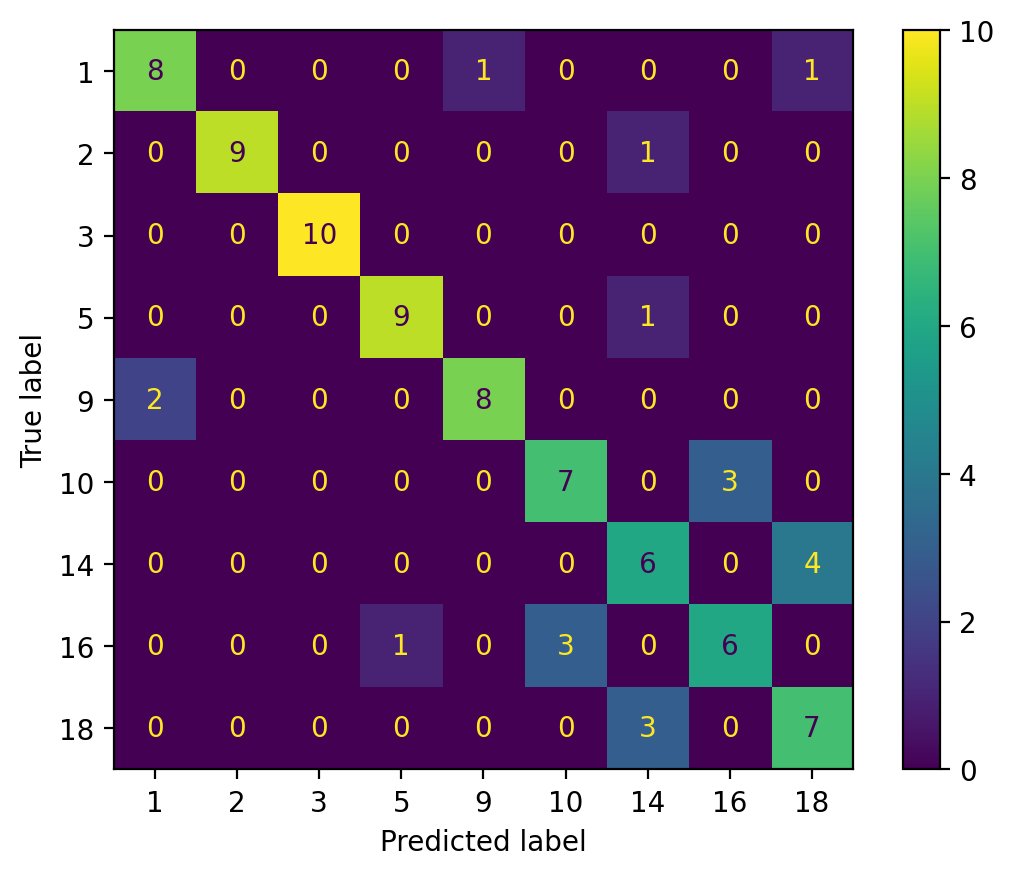

In [6]:
# PREPARE DATASET FOR TRAINING 
all_tracks_id = []
for track in get_all_id_tracks():
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if os.path.exists(path):
            all_tracks_id.append(track)
df = pd.DataFrame({
    'track_id': all_tracks_id,
    'tab': get_id_label('tab')
    })

df = df[df['tab'].isin(TAB_LIST_TRAIN)]
#df.info()
actual = []
pred = []
overall_acc = []

y_test, y_pred, overall_acc = skf_model_matching('tab', df, random_state= 42, k= 10, test_dim=1, std=30)
print_performance(y_test, y_pred, overall_acc)

9b546274-eea6-459f-a0c2-918f0997fa2b
495.75
33423585-e406-40ec-ba28-88b0768cb668
702.0
92de6fc8-a040-4500-bd94-73e9ee39f189
870.25
b3d92934-0946-4f2d-8183-312450d7e45e
1069.5
023b4a37-1ab4-4593-b03a-850ee0db8350
1469.0
6fe7108c-4e4f-457b-a363-ccf505bdee9a
1612.0
a1eac726-208e-4c24-bd57-e34e9e93dcd3
1808.5
4342021d-03a1-4727-8c0f-3c23180ef374
1895.75
3e5a82a2-d806-45cc-876e-6fa8a2b5a61d
1934.25
e3003cd0-430a-4481-a33d-c15c22da2404
2140.5
d4cadf34-1074-44ce-9928-f438198d5d6d
2166.75
97223154-d5c2-4c37-8e6c-4c998056a674
2166.75
2d2683c4-4b3e-4430-a254-c828427bdcc7
2197.75
e22549ae-4a0c-43ef-87f4-e0f81ed49d58
2416.5
679856bc-132f-4982-b04e-cbf6b5b1129b
2578.25
cb85269e-ab6c-4226-aea1-8226be1fe86c
2786.5
5eb3c226-d289-40fe-a9f4-697568eb37d5
2824.25
1630e9c2-3c01-4959-a633-7dbacbc7616e
3034.25
c20e4852-d140-4909-acab-e850c0e7d8e8
3172.75
f461045b-50bc-4b20-a731-66fbd3a264ae
3403.25
44183247-4857-40cd-82bc-b4e9e3f458f1
3441.75
2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e
<music21.chord.Chord B4 A#5 B

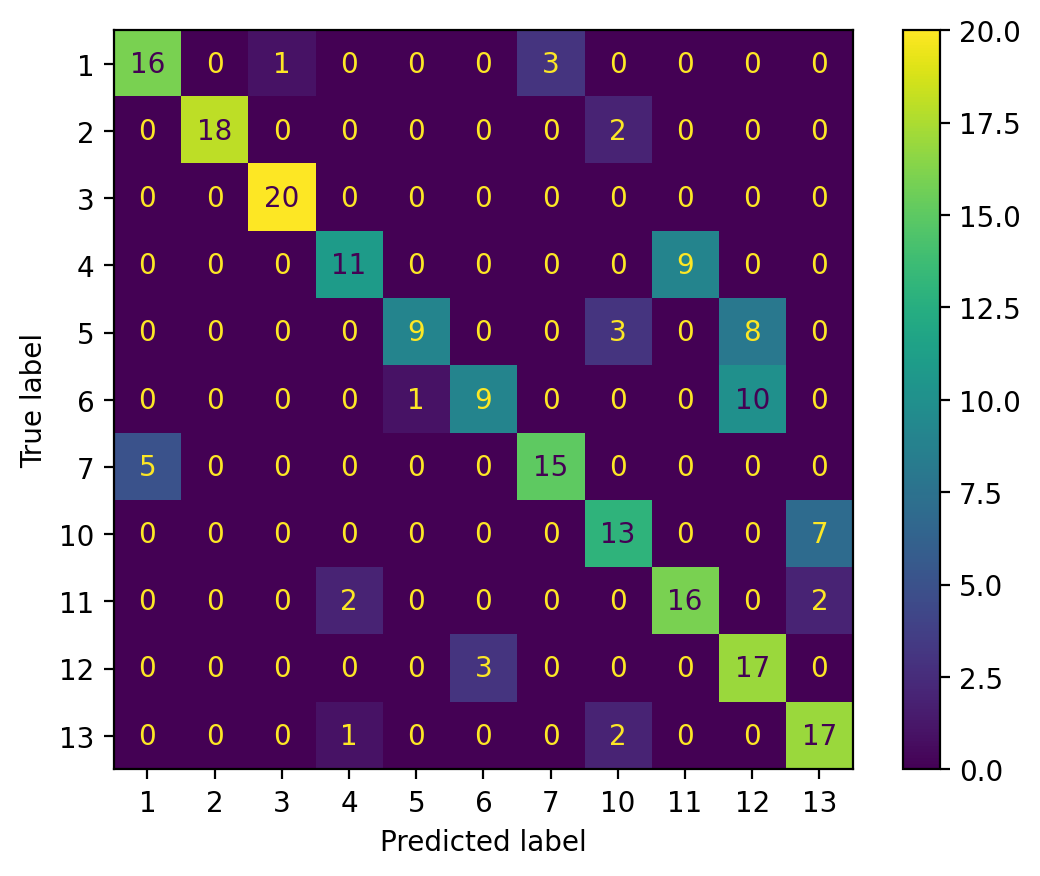

In [4]:
# PREPARE DATASET FOR TRAINING 
all_tracks_id = []
for track in get_all_id_tracks():
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if os.path.exists(path):
            all_tracks_id.append(track)
df = pd.DataFrame({
    'track_id': all_tracks_id,
    'nawba': get_id_label('nawba')
    })

df = df[df['nawba'].isin(LABEL_LIST_TRAIN["nawba"])]
#df.info()
actual = []
pred = []
overall_acc = []

y_test, y_pred, overall_acc = skf_model_matching('nawba', df, random_state= 42, k= 20, test_dim=1, std=30)
print_performance(y_test, y_pred, overall_acc)

In [41]:
from sklearn.model_selection import StratifiedKFold
#def skf_model_matching_sections(label, random_state, k, test_dim, std, overlap, sequence_length):
"""
Parameters:
    df: dataframe with track id and target label
    std: standard deviation value to compute gaussina smoothening with
    label: target label to perform the experiment on
    test_dim: Number of samples to take in the test set
-------------------------------------------------------------------

Perfoms the model matching experiment by gathering tracks and computing the model of each label.
Computes histogram into models and then compares it to each comprehensive target label model.
"""
# PREPARE DATASET FOR TRAINING
label = "tab"
random_state= 5
k= 10 
test_dim=1
std=30
overlap= 0.1
sequence_length=2048
df, pitch_distr_sections, ql_distr_sections = prepare_dataframe(label, overlap, sequence_length)
prefixes, prefixes_y, prefix_to_ids = return_prefixes(df, label)
overall_acc= []
actual = []
predicted = []
y_model_list = []
skf = StratifiedKFold(n_splits=k)
# Stratified K-Fold Cross-Validation LOOP


In [ ]:

for i, (train_index, test_index) in enumerate(skf.split(prefixes, prefixes_y)):
    print(f" {i},", end="")  
    random.seed(random_state)
    np.random.seed(random_state)
    #train_prefixes, test_prefixes = train_test_split(prefixes, stratify=prefixes_y, test_size=0.2, random_state=random_state)
    train_prefixes = prefixes[train_index]
    test_prefixes= prefixes[test_index]
    # Step 3: Gather IDs for train and test sets
    train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]

    #compare_plot_label_distribution(df_windowed, df_notes)
    shuffled_df = df.sample(frac=1, random_state=random_state)
    # Group by 'section_id'
    grouped = shuffled_df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', label]]
    # Create an array for each group

    group_arrays = {section_id: group.values for section_id, group in grouped}
    sequences_features = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for key, values in group_arrays.items():
        if key in train_ids:
            X_train.append(pitch_distr_sections[key])
            y_train.append((values[0][-1]))
        else:
            X_test.append(pitch_distr_sections[key])
            y_test.append((values[0][-1]))

        sequences_features.append(pitch_distr_sections[key])
    sequences_features = [list(x) for x in sequences_features]
    X_train = [list(x) for x in X_train]
    X_test = [list(x) for x in X_test]
    
    # CREATE TEMPLATES FOR EACH LABEL
    y_model_list = []
    for label_t2 in LABEL_LIST_TRAIN[label]:
        filtered_X_train = [x for x, y in zip(X_train, y_train) if y == label_t2]
        summed_hist = np.sum(filtered_X_train, axis=0)
        
        #tot_y_temp = sum(summed_hist)
        #tot_y_temp[:] = [y / tot_y_temp for y in tot_y_temp]
    
        #_, y_temp = compute_avg_folded_hist_scores(X_train.loc[X_train[label] == label_t2, 'track_id'].tolist())        
        _, y_model = convert_folded_scores_in_models([summed_hist], std)
        y_model_list.append(y_model[0])

    # COMPUTE MODEL OF TEST SAMPLES
    curr_acc = []
    for i in range(len(X_test)):
        #summed_hist = sum(X_test[i])
        
        #tot_y_temp = X_test[i]
        #tot_y_temp[:] = [y / tot_y_temp for y in tot_y_temp]
        _, y_model_list_test = convert_folded_scores_in_models([X_test[i]], std)

        # RUN ACCURACY TEST
        label_score = []
        for l, label_t3 in enumerate(LABEL_LIST_TRAIN[label]):
            label_score.append((get_distance(y_model_list_test[0], y_model_list[l], 'L2'), label_t3))
        
        curr_acc.append(y_test[i] == min(label_score)[1])
        actual.append(y_test[i])
        predicted.append(min(label_score)[1])
    overall_acc.append(sum(curr_acc) / len(curr_acc))
    
#return actual, predicted, overall_acc  

#y_test, y_pred, overall_acc = skf_model_matching_sections('tab', random_state= 5, k= 10, test_dim=1, std=30, overlap= 0.5, sequence_length=256)

 0,[0.18932443703085905, 0.0, 0.2588268001112038, 0.0, 0.2666110647762024, 0.040589380038921326, 0.013900472616068946, 0.12482624409229914, 0.0, 0.08507089241034195, 0.0, 0.020850708924103418]
[0.11084220716360116, 0.0, 0.13843175217812198, 0.0, 0.11616650532429816, 0.16989351403678607, 0.0, 0.18211519845111326, 0.0, 0.23366408518877058, 0.005808325266214908, 0.043078412391093904]
[0.14406130268199233, 0.0, 0.07075351213282248, 0.0007662835249042146, 0.30983397190293743, 0.1243933588761175, 0.013026819923371647, 0.22579821200510855, 0.0, 0.08556832694763729, 0.0, 0.025798212005108557]
[0.10317887931034483, 0.0, 0.21982758620689655, 0.011853448275862068, 0.16998922413793102, 0.012661637931034482, 0.0738146551724138, 0.19827586206896552, 0.0, 0.10910560344827586, 0.0, 0.10129310344827586]
[0.12460815047021943, 0.0, 0.2533307210031348, 0.0, 0.11108934169278997, 0.14968652037617555, 0.001959247648902821, 0.20356583072100312, 0.0, 0.0636755485893417, 0.001567398119122257, 0.0905172413793103

Precision: 0.646552
Std. Deviation: 0.0998
Weighted recall for each class: 0.630908
Global recall: 0.646552
F1 score: 0.646552


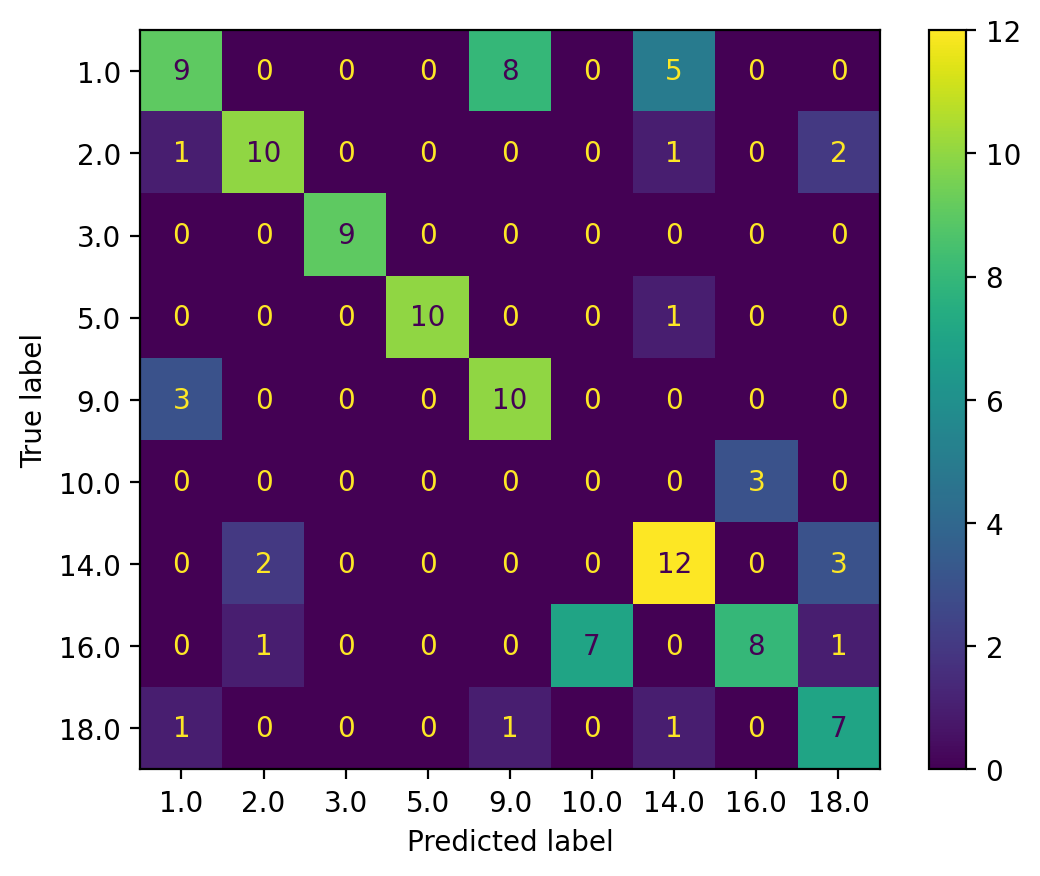

In [43]:
print_performance(actual, predicted, overall_acc)